In [1]:
from pyCodeLib import *
import warnings
import glob
import re
import numpy as np
warnings.filterwarnings('ignore')


# sys.path.insert(0, MYHOME)
%load_ext autoreload
%autoreload 2

In [11]:
pre = "/Users/weilu/Research/server/feb_2019/gammas_by_shuffle/"
A_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_A"
B_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_B"
B_filtered_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_B_filtered"
P_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_P"
Gamma_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_gamma"
Gamma_filtered_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_gamma_filtered"
Lamb_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_lamb"
Lamb_filtered_name = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0_lamb_filtered"

A = np.loadtxt(pre+A_name)
B = np.loadtxt(pre+B_name)
B_filtered = np.loadtxt(pre+B_filtered_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})
Gamma = np.loadtxt(pre+Gamma_name)
Gamma_filtered = np.loadtxt(pre+Gamma_filtered_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})
Lamb = np.loadtxt(pre+Lamb_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})
Lamb_filtered = np.loadtxt(pre+Lamb_filtered_name, dtype=complex, converters={
                           0: lambda s: complex(s.decode().replace('+-', '-'))})


In [52]:
def get_filtered_gamma_B_lamb_P_and_lamb(A, B, half_B, other_half_B, std_half_B, total_phis, num_decoys, noise_iterations=10, relative_error_threshold=0.5):
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)

    cutoff_modes = []
    for i_noise in range(noise_iterations):
        noisy_B = np.zeros((total_phis, total_phis))
        for i in range(total_phis):
            for j in range(i, total_phis):
                random_B_ij = np.random.normal(
                    loc=half_B[i][j], scale=std_half_B[i][j] / float(num_decoys))
                noisy_B[i][j] = noisy_B[j][i] = random_B_ij - \
                    other_half_B[i][j]

        noisy_lamb, noisy_P = np.linalg.eig(noisy_B)
        noisy_lamb, noisy_P = sort_eigenvalues_and_eigenvectors(
            noisy_lamb, noisy_P)

        try:
            cutoff_mode = np.where(
                np.abs(lamb - noisy_lamb) / lamb > relative_error_threshold)[0][0]
        except IndexError:
            cutoff_mode = len(lamb)
        cutoff_modes.append(cutoff_mode)

    cutoff_mode = min(cutoff_modes)
    print(cutoff_mode)

    filtered_lamb = np.copy(lamb)
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(
        filtered_lamb, cutoff_mode, P)

    filtered_gamma = np.dot(filtered_B_inv, A)
    filtered_B = np.linalg.inv(filtered_B_inv)
    return filtered_gamma, filtered_B, filtered_lamb, P, lamb
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors



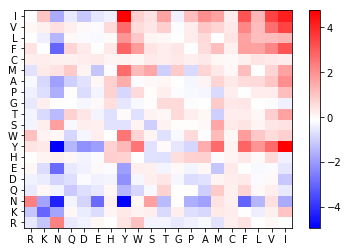

In [34]:
plot_contact_well(Gamma[:210], inferBound=True)

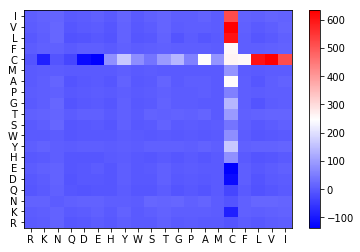

In [35]:
plot_contact_well(Gamma_filtered[:210], inferBound=True)

In [70]:
Gamma_filtered[74]

(-265.87613-0j)

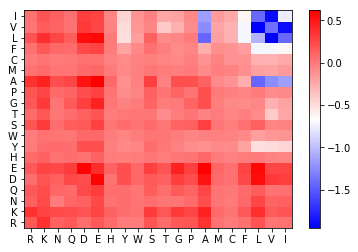

In [25]:
plot_contact_well(A[:210], inferBound=True, invert_sign=False)

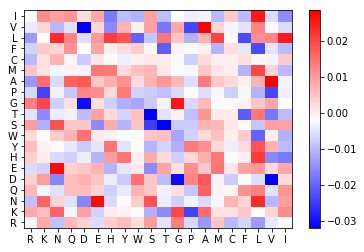

In [26]:
plot_contact_well(A[210:420], inferBound=True, invert_sign=False)

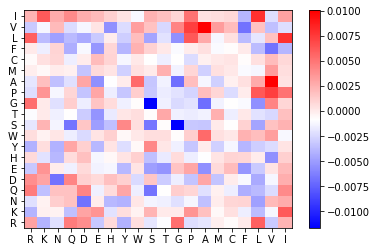

In [27]:
plot_contact_well(A[420:], inferBound=True, invert_sign=False)

In [3]:
os.chdir('/Users/weilu/opt/notebook/Optimization')

In [5]:
pre = "/Users/weilu/Research/server/feb_2019/jan_optimization/"
os.chdir(pre)
a_list = []
with open(pre+"database/cath-dataset-nonredundant-S20Clean.list") as f:
    for i, line in enumerate(f):
        a = line.strip()
        save = False
        decoy_pairwise = f"phis/phi_pairwise_contact_well_{a}_decoys_shuffle_4.5_6.5_5.0_10"
        decoy_mediated = f"phis/phi_density_mediated_contact_well_{a}_decoys_shuffle_6.5_9.5_5.0_10_2.6_7.0"
        native_pairwise = f"phis/phi_pairwise_contact_well_{a}_native_4.5_6.5_5.0_10"
        native_mediated = f"phis/phi_density_mediated_contact_well_{a}_native_6.5_9.5_5.0_10_2.6_7.0"
        if not os.path.exists(decoy_pairwise):
            print("decoy_pairwise", a)
            save = True
        if not os.path.exists(decoy_mediated):
            print("decoy_mediated", a)
            save = True
        if not os.path.exists(native_mediated):
            print("native_mediated", a)
            save = True
        if not os.path.exists(native_pairwise):
            print("native_pairwise", a)
            save = True
        if save:
            a_list.append(a)
#         break

decoy_pairwise 1s3jA02
decoy_pairwise 1twfC01
decoy_pairwise 1wpqA01
decoy_pairwise 2jn4A00
decoy_pairwise 2l7kA00
decoy_mediated 2o8bB01
decoy_pairwise 2ookA00
decoy_pairwise 2ortA03
decoy_pairwise 2r17C00
decoy_mediated 2r39A00
decoy_pairwise 2ri9A00
decoy_mediated 2rnoA00
decoy_pairwise 2wk1A00
decoy_pairwise 2xpiD00
decoy_pairwise 2yh6D00
decoy_pairwise 2yhcA00
decoy_pairwise 2yhgA02
decoy_pairwise 2yijA00
decoy_mediated 3ab8A00
decoy_pairwise 3abzA01
decoy_pairwise 3bzwA00
decoy_pairwise 3dkqA02
decoy_mediated 3grlA00
decoy_pairwise 3igrA00
decoy_pairwise 3jc6601
decoy_mediated 3jrvA00
decoy_pairwise 3jszA01
decoy_mediated 3k1tA02
decoy_mediated 3kboA02
decoy_mediated 3kbrA02
decoy_mediated 3kd4A02
decoy_pairwise 3kwlA03
decoy_pairwise 3lo7A01
decoy_pairwise 3nl6B01
decoy_pairwise 3nlcA01
decoy_pairwise 3nnkA02
decoy_pairwise 3oceA03
decoy_pairwise 3pxgA04
decoy_mediated 3rnvA00
decoy_pairwise 3thoA01
decoy_pairwise 3tnzA01
decoy_mediated 3vhlA02
decoy_pairwise 3w9fC00
decoy_media

In [6]:
len(a_list)

61

In [7]:
with open("fix_1.txt", "w") as out:
    for i in a_list:
        out.write(i+"\n")

In [6]:
pre = "/Users/weilu/Research/server/feb_2019/jan_optimization/"
os.chdir(pre)
with open(pre+"database/cath-dataset-nonredundant-S20Clean.list") as f:
    for line in f:
        a = line.strip()
        li = glob.glob(f"phis/*{a}*")
        if len(li) != 4:
            print(li)
#         break

['phis/phi_pairwise_contact_well_1914A00_decoys_shuffle_4.5_6.5_5.0_10', 'phis/phi_density_mediated_contact_well_1914A00_native_6.5_9.5_5.0_10_2.6_7.0', 'phis/phi_pairwise_contact_well_1914A00_native_4.5_6.5_5.0_10']
['phis/phi_density_mediated_contact_well_1c7tA03_native_6.5_9.5_5.0_10_2.6_7.0', 'phis/phi_density_mediated_contact_well_1c7tA03_decoys_shuffle_6.5_9.5_5.0_10_2.6_7.0', 'phis/phi_pairwise_contact_well_1c7tA03_native_4.5_6.5_5.0_10']
['phis/phi_pairwise_contact_well_1s3jA02_native_4.5_6.5_5.0_10', 'phis/phi_density_mediated_contact_well_1s3jA02_native_6.5_9.5_5.0_10_2.6_7.0', 'phis/phi_density_mediated_contact_well_1s3jA02_decoys_shuffle_6.5_9.5_5.0_10_2.6_7.0']
['phis/phi_density_mediated_contact_well_1twfC01_native_6.5_9.5_5.0_10_2.6_7.0', 'phis/phi_pairwise_contact_well_1twfC01_native_4.5_6.5_5.0_10', 'phis/phi_density_mediated_contact_well_1twfC01_decoys_shuffle_6.5_9.5_5.0_10_2.6_7.0']
['phis/phi_density_mediated_contact_well_1wpqA01_native_6.5_9.5_5.0_10_2.6_7.0', 'ph

KeyboardInterrupt: 

In [77]:
lamb, P = np.linalg.eig(B)

In [84]:
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)

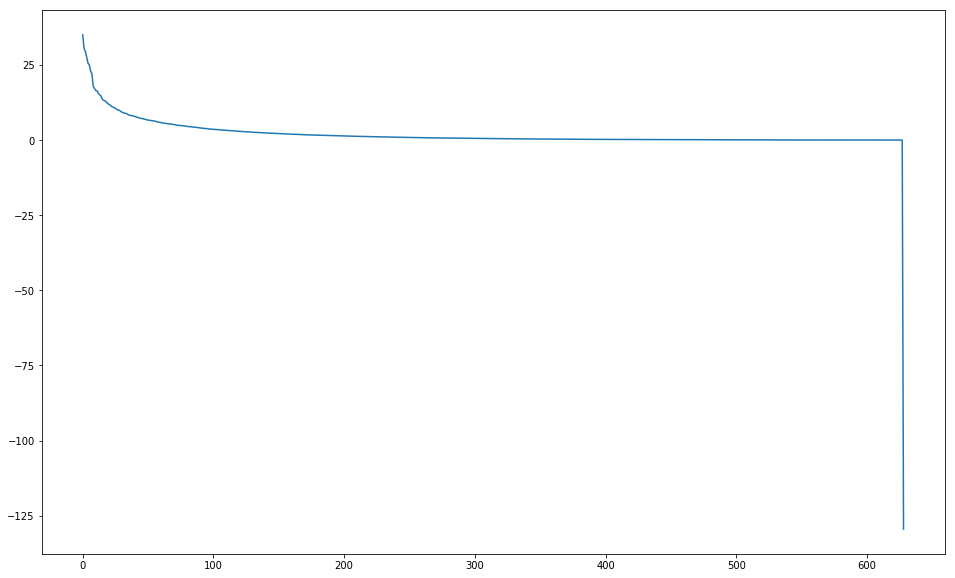

In [85]:
plt.plot(lamb[1:])

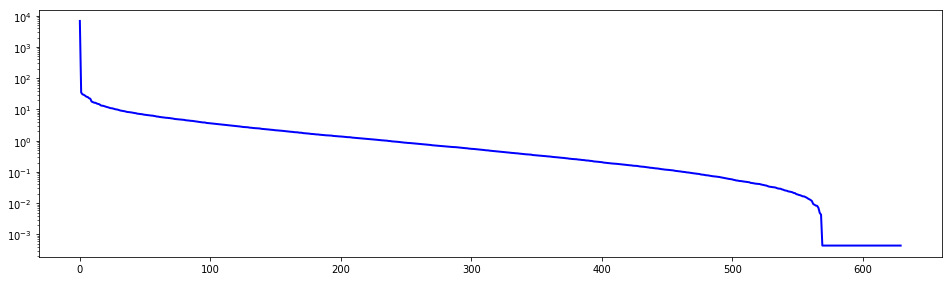

In [83]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(Lamb_filtered, color='blue', lw=2)
ax.set_yscale('log')

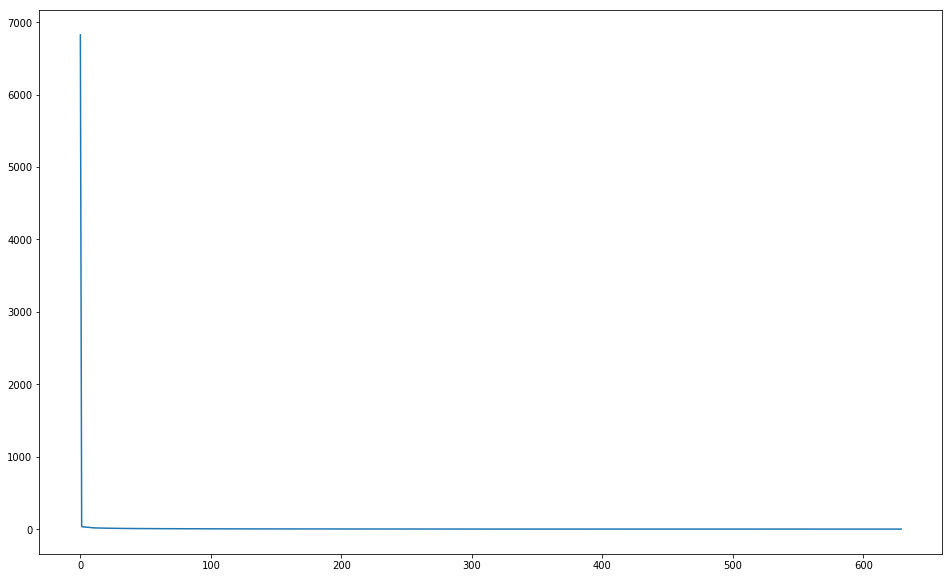

In [80]:
plt.plot(Lamb_filtered)

In [107]:
a = np.arange(8).reshape(2,4)

In [108]:
a

array([[0, 1, 2, 3],
       [4, 5, 6, 7]])

In [109]:
a.reshape(2, 1, 4)

array([[[0, 1, 2, 3]],

       [[4, 5, 6, 7]]])

In [113]:
b = a.reshape(2,4,1) * a.reshape(2, 1, 4)

In [114]:
b

array([[[ 0,  0,  0,  0],
        [ 0,  1,  2,  3],
        [ 0,  2,  4,  6],
        [ 0,  3,  6,  9]],

       [[16, 20, 24, 28],
        [20, 25, 30, 35],
        [24, 30, 36, 42],
        [28, 35, 42, 49]]])

In [115]:
np.sum(b, axis=0)

array([[16, 20, 24, 28],
       [20, 26, 32, 38],
       [24, 32, 40, 48],
       [28, 38, 48, 58]])

In [105]:
b.shape

(3, 5, 5)

In [71]:
P.shape

(630, 630)

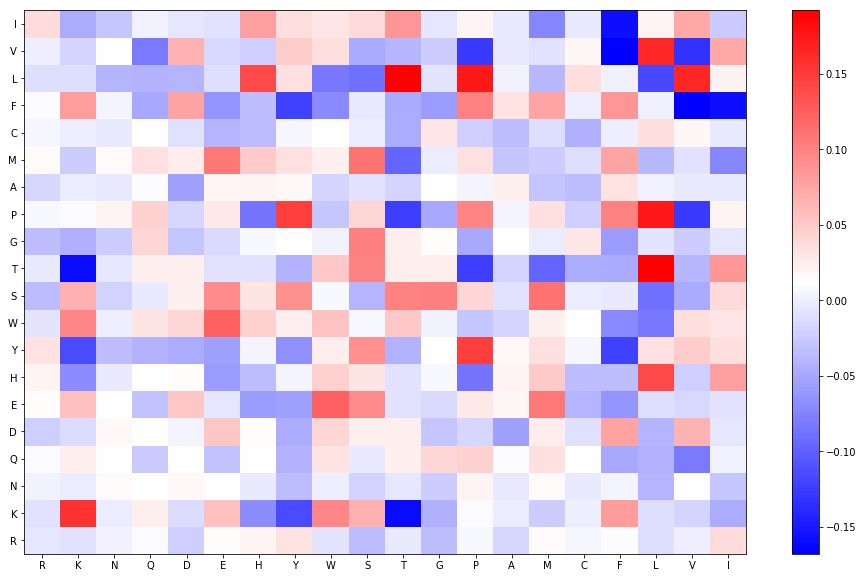

In [78]:
plot_contact_well(P[0][:210], inferBound=True)

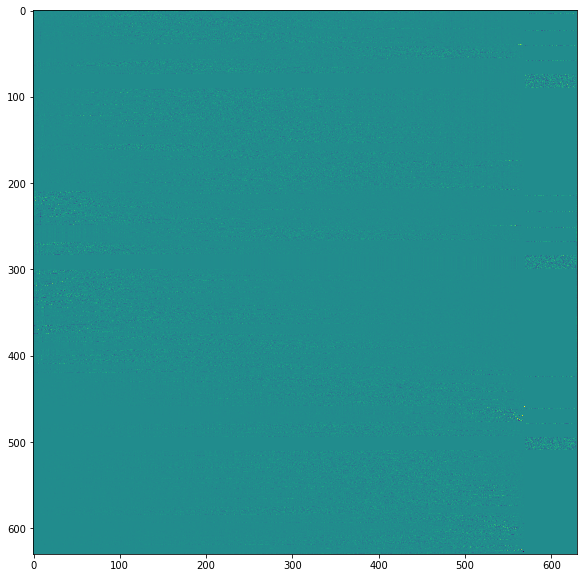

In [72]:
plt.imshow(P)

In [51]:
np.allclose(Lamb.astype(float), lamb, atol=1e-4)

True

In [57]:
cys_cys = 4*20+4

In [59]:
np.argmax(B[:210,:210])

2110

In [61]:
np.max(B[:210,:210])

40.19161

In [90]:
a = np.ones((10,20,30))

In [92]:
np.sum(a, axis=0).shape

(20, 30)

In [94]:
np.average(np.sum(a, axis=0), axis=0).shape

(30,)

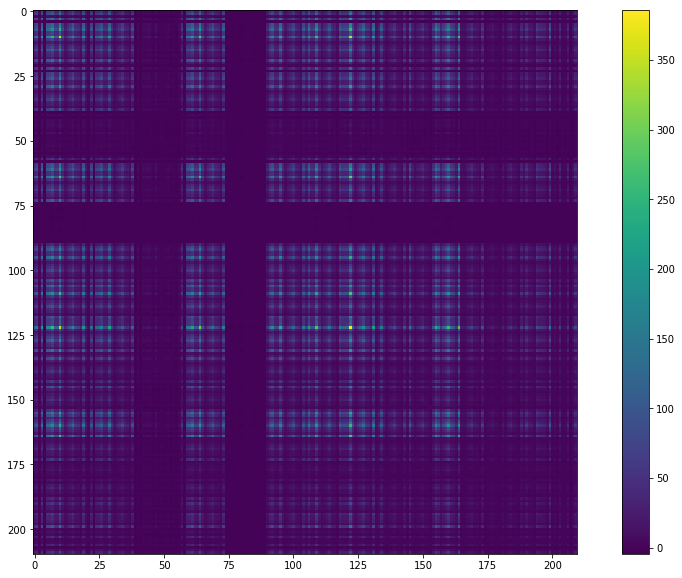

In [87]:
plt.rcParams['figure.figsize'] = [16.18033, 10]
plt.imshow(B[210:420,210:420])
plt.colorbar()

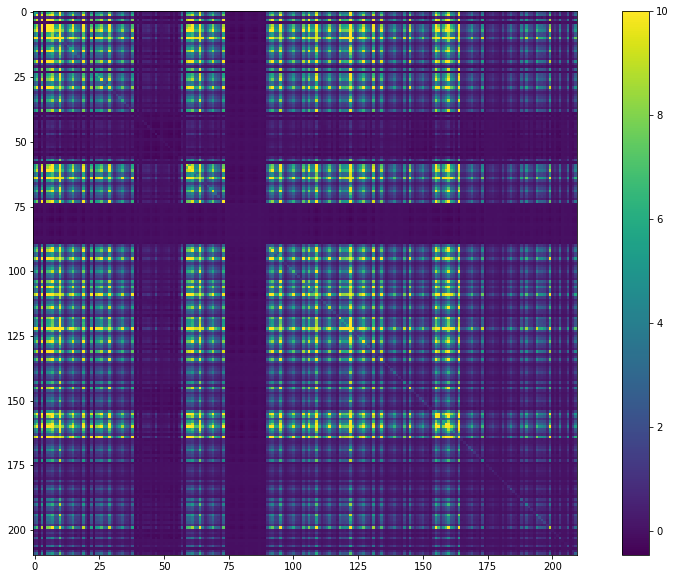

In [63]:
plt.rcParams['figure.figsize'] = [16.18033, 10]
plt.imshow(B[:210,:210], vmax=10)
plt.colorbar()

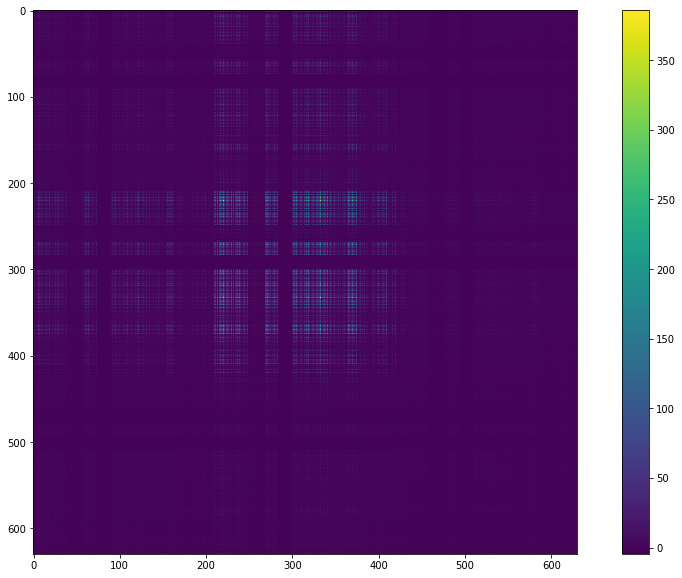

In [55]:
plt.rcParams['figure.figsize'] = [16.18033, 10]
plt.imshow(B)
plt.colorbar()

In [ ]:
get_filtered_gamma_B_lamb_P_and_lamb(A, B, )

In [44]:
max(Lamb.astype(float) - lamb)

4.1096429469145936e-05

In [32]:
Lamb.astype(float)

array([ 6.8233289e+03,  3.4976580e+01,  3.0545410e+01,  2.9474000e+01,
        2.7681690e+01,  2.5600540e+01,  2.5077520e+01,  2.2942070e+01,
        2.2126370e+01,  1.7950930e+01,  1.7159250e+01,  1.6468140e+01,
        1.6367150e+01,  1.5478510e+01,  1.5060640e+01,  1.4637770e+01,
        1.3523500e+01,  1.3222230e+01,  1.3055410e+01,  1.2638740e+01,
        1.2212780e+01,  1.1867080e+01,  1.1615440e+01,  1.1167710e+01,
        1.0951160e+01,  1.0855430e+01,  1.0485550e+01,  1.0213200e+01,
        1.0050100e+01,  9.8768400e+00,  9.5519100e+00,  9.2639400e+00,
        9.1072700e+00,  8.9486500e+00,  8.8620100e+00,  8.6508500e+00,
        8.3652700e+00,  8.2896700e+00,  8.1540900e+00,  8.0927600e+00,
        7.9849700e+00,  7.8270700e+00,  7.6701500e+00,  7.5829100e+00,
        7.3511200e+00,  7.2843900e+00,  7.1640200e+00,  7.0996900e+00,
        7.0174500e+00,  6.8429800e+00,  6.7546700e+00,  6.6129700e+00,
        6.5849200e+00,  6.5260500e+00,  6.4126400e+00,  6.3589300e+00,
      

In [39]:
lamb

array([ 6.82332889e+03,  3.49765773e+01,  3.05454052e+01,  2.94739973e+01,
        2.76816884e+01,  2.56005443e+01,  2.50775218e+01,  2.29420786e+01,
        2.21263831e+01,  1.79509266e+01,  1.71592610e+01,  1.64681422e+01,
        1.63671472e+01,  1.54784993e+01,  1.50606418e+01,  1.46377726e+01,
        1.35234948e+01,  1.32222298e+01,  1.30554228e+01,  1.26387470e+01,
        1.22127807e+01,  1.18670830e+01,  1.16154438e+01,  1.11677113e+01,
        1.09511531e+01,  1.08554288e+01,  1.04855571e+01,  1.02131959e+01,
        1.00500949e+01,  9.87683106e+00,  9.55190883e+00,  9.26393473e+00,
        9.10726331e+00,  8.94865005e+00,  8.86201213e+00,  8.65084745e+00,
        8.36526079e+00,  8.28965891e+00,  8.15408386e+00,  8.09275901e+00,
        7.98497434e+00,  7.82707312e+00,  7.67015090e+00,  7.58291047e+00,
        7.35112940e+00,  7.28438331e+00,  7.16402729e+00,  7.09968540e+00,
        7.01744496e+00,  6.84297705e+00,  6.75466702e+00,  6.61296201e+00,
        6.58492480e+00,  

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   2.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,   4.,
          3.,   6.,   6.,  17., 305., 178.,  25.,  16.,  14.,  13.,  13.,
          4.,   3.,   2.,   0.,   2.,   3.]),
 array([-1.9499000e+00, -1.8985568e+00, -1.8472136e+00, -1.7958704e+00,
        -1.7445272e+00, -1.6931840e+00, -1.6418408e+00, -1.5904976e+00,
        -1.5391544e+00, -1.4878112e+00, -1.4364680e+00, -1.3851248e+00,
        -1.3337816e+00, -1.2824384e+00, -1.2310952e+00, -1.1797520e+00,
        -1.1284088e+00, -1.0770656e+00, -1.0257224e+00, -9.7437920e-01,
        -9.2303600e-01, -8.7169280e-01, -8.2034960e-01, -7.6900640e-01,
        -7.1766320e-01, -6.6632000e-01, -6.1497680e-01, -5.6363360e-01,
        -5.1229040e-01, -4.6094720e-01, -4.0960400e-01, -3.5826080e-01,
        -3.0691760e-01, -2.5557440e-01, -2.0423120e-01, -1.5288800e-01,
        -1

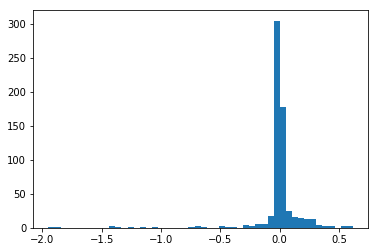

In [15]:
plt.hist(A, bins=50)

In [12]:
B.shape

(630, 630)

In [18]:
import Bio.PDB as bio
one_to_index = bio.Polypeptide.one_to_index

In [5]:
A.shape

(630,)